In [3]:
### from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [4]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [5]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [6]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [7]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoder_weights_0.5sec_vhpc'

In [8]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'max_val', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'plot_scores', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within_subset', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within_weights', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'gini', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)


In [7]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [8]:
all_animals =     'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
pre_animals =     'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
post_animals =    'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
pre_rev_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
post_rev_animals ='c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
catch_animals =   'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'

In [9]:
sessions = 'pre', 'post', 'pre_rev', 'post_rev', 'catch'

In [10]:
for sess in sessions:
    for dur in 5,: #use 5 for 0.5sec, 1 for 1 sec and 2 for 2sec
        exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb_%s_%s',\
                                                           '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess,dur,sess))
        exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                         '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                  for ani in %s_animals]))"%(sess,sess,sess,sess))

In [11]:
relabel_rwVSsh = {0:-1,1:1,2:0}
relabel_rwVScsm = {0:0,1:1,2:-1}
relabel_shVScsm = {0:0,1:-1,2:1}
for sess in sessions:
    exec("labels_rwVSsh_%s = {}"%sess)
    exec("labels_rwVScsm_%s = {}"%sess)
    exec("labels_shVScsm_%s = {}"%sess)
    for ani in eval("%s_animals"%sess):
        exec("labels_rwVSsh_%s[ani] = np.r_[[relabel_rwVSsh[l] for l in labels_%s[ani]]]"%(sess,sess))
        exec("labels_rwVScsm_%s[ani] = np.r_[[relabel_rwVScsm[l] for l in labels_%s[ani]]]"%(sess,sess))
        exec("labels_shVScsm_%s[ani] = np.r_[[relabel_shVScsm[l] for l in labels_%s[ani]]]"%(sess,sess))

In [12]:
#delta_t0 = 0.5sec
#from referenced notebook, 28 time bins total beginning at 3s prior to odor onset and running through 10.5s post onset

#t_start0 = -3  # sec
#t_stop0 = 11  # sec
# CS BEGINS WITH TIME BIN 7 (tb6)
# TRACE BEGINS AT TB 11
# REWARD DELIVERED AT TB 15

In [8]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within(patterns, labels, n_cells=None):
   
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [9]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_subset(patterns, labels, cells):
   
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [10]:
from sklearn.svm import SVC
def do_test_within_weights(patterns, labels):
    
    patterns_comb_weights, labels_comb_weights = ut.combine_patterns(patterns, labels)
    decoder.fit(patterns_comb_weights,labels_comb_weights)
    weights = decoder.coef_[0]
    return weights

In [11]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [17]:
for sess in sessions:
    for t in range(25):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 90 pre 91 pre 92 pre 93 pre c3f3 pre c3f2 pre c3m1 pre c3m2 pre c4m4 pre c10m6 pre c10m8 pre 9

In [18]:
%%time
n_loops = 30

for vs in 'rwVScsm','shVScsm','rwVSsh':
    for t in range(25): # number of time bins
        exec('scores_%s_tb_%s = {}'%(vs,t))
        for sess in sessions:
            print sess,t,vs,
            eval("scores_%s_tb_%s"%(vs,t))[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s_%s'%(vs,sess))) for i in range(n_loops)]]

pre 0 rwVScsm post 0 rwVScsm pre_rev 0 rwVScsm post_rev 0 rwVScsm catch 0 rwVScsm pre 1 rwVScsm post 1 rwVScsm pre_rev 1 rwVScsm post_rev 1 rwVScsm catch 1 rwVScsm pre 2 rwVScsm post 2 rwVScsm pre_rev 2 rwVScsm post_rev 2 rwVScsm catch 2 rwVScsm pre 3 rwVScsm post 3 rwVScsm pre_rev 3 rwVScsm post_rev 3 rwVScsm catch 3 rwVScsm pre 4 rwVScsm post 4 rwVScsm pre_rev 4 rwVScsm post_rev 4 rwVScsm catch 4 rwVScsm pre 5 rwVScsm post 5 rwVScsm pre_rev 5 rwVScsm post_rev 5 rwVScsm catch 5 rwVScsm pre 6 rwVScsm post 6 rwVScsm pre_rev 6 rwVScsm post_rev 6 rwVScsm catch 6 rwVScsm pre 7 rwVScsm post 7 rwVScsm pre_rev 7 rwVScsm post_rev 7 rwVScsm catch 7 rwVScsm pre 8 rwVScsm post 8 rwVScsm pre_rev 8 rwVScsm post_rev 8 rwVScsm catch 8 rwVScsm pre 9 rwVScsm post 9 rwVScsm pre_rev 9 rwVScsm post_rev 9 rwVScsm catch 9 rwVScsm pre 10 rwVScsm post 10 rwVScsm pre_rev 10 rwVScsm post_rev 10 rwVScsm catch 10 rwVScsm pre 11 rwVScsm post 11 rwVScsm pre_rev 11 rwVScsm post_rev 11 rwVScsm catch 11 rwVScsm pre 12

In [19]:
%%time
#get decoder weights for each cell
n_loops=100

for vs in 'rwVScsm','shVScsm','rwVSsh':
    for t in range(25): # number of time bins
        exec('weights_%s_tb_%s = {}'%(vs,t))
        for sess in sessions:
            print sess,t,
            eval("weights_%s_tb_%s"%(vs,t))[sess] = [do_test_within_weights(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s_%s'%(vs,sess))) for i in range(n_loops)]

pre 0 post 0 pre_rev 0 post_rev 0 catch 0 pre 1 post 1 pre_rev 1 post_rev 1 catch 1 pre 2 post 2 pre_rev 2 post_rev 2 catch 2 pre 3 post 3 pre_rev 3 post_rev 3 catch 3 pre 4 post 4 pre_rev 4 post_rev 4 catch 4 pre 5 post 5 pre_rev 5 post_rev 5 catch 5 pre 6 post 6 pre_rev 6 post_rev 6 catch 6 pre 7 post 7 pre_rev 7 post_rev 7 catch 7 pre 8 post 8 pre_rev 8 post_rev 8 catch 8 pre 9 post 9 pre_rev 9 post_rev 9 catch 9 pre 10 post 10 pre_rev 10 post_rev 10 catch 10 pre 11 post 11 pre_rev 11 post_rev 11 catch 11 pre 12 post 12 pre_rev 12 post_rev 12 catch 12 pre 13 post 13 pre_rev 13 post_rev 13 catch 13 pre 14 post 14 pre_rev 14 post_rev 14 catch 14 pre 15 post 15 pre_rev 15 post_rev 15 catch 15 pre 16 post 16 pre_rev 16 post_rev 16 catch 16 pre 17 post 17 pre_rev 17 post_rev 17 catch 17 pre 18 post 18 pre_rev 18 post_rev 18 catch 18 pre 19 post 19 pre_rev 19 post_rev 19 catch 19 pre 20 post 20 pre_rev 20 post_rev 20 catch 20 pre 21 post 21 pre_rev 21 post_rev 21 catch 21 pre 22 post 22 p

In [20]:
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for t in range(25): # number of time bins
        exec("avg_weights_%s_tb_%s ={}"%(vs,t))
        exec("abs_avg_weights_%s_tb_%s={}"%(vs,t))
        for sess in sessions:
            exec("avg_weights_%s_tb_%s[sess] = [np.mean(k) for k in zip(*weights_%s_tb_%s[sess])]"%(vs,t,vs,t))
            exec("abs_avg_weights_%s_tb_%s[sess] = map(abs,avg_weights_%s_tb_%s[sess])"%(vs,t,vs,t))

In [21]:
#fig, ax = pl.subplots(6,1, figsize=(2.5, 10))
#i=-1
#
#for sess in sessions:
#    i=i+1
#    x = abs_avg_weights_tb_12[sess]
#    y = abs_avg_weights_tb_17[sess]
#    ax[i].plot(x,y,'bo',markersize=.8,mew=.1,scalex=False,scaley=False)
#    #ax[i].set_xlim(-.08,.08)
#    #ax[i].set_ylim(-.08,.08)
#    for tb,lc,d in zip(('13','14','15','16','17','18','19'),('r','orange','g','cyan','b','purple','k'),
#                       ('1.5','2.0','2.5','3.0','3.5','4.0','4.5')):
#        y = eval("abs_avg_weights_tb_%s[sess]"%tb)
#        slope, intercept, r_value, p_value, std_err = sstats.linregress(x,y)
#        line = slope*(np.unique(x))+intercept
#        r2 = r_value*r_value
#        ax[i].plot(np.unique(x), line, '%s'%lc, label='1 vs {}s, r$^2$={:.2f}'.format(d,r2))
#    ax[i].set_title(sess)
#    ax[0].set_title('expo\ntb 1.0s vs tb x')
#ax[0].legend(loc='best',prop={'size': 3})
#pl.xlabel("decoder weights, tb 1.0",fontsize=5)
#pl.ylabel("decoder weights, tb x",fontsize=5)
##pl.xlim(-.08,.08)
##pl.ylim(-.08,.08)
#fig.tight_layout(pad=3)

In [22]:
reference_tbs = range(25)

In [23]:
##find Gini coef and lorenz curve for ref_tbs
#def Gini(v):
#    bins = np.linspace(0., 100., 11)
#    total = float(np.sum(v))
#    yvals = []
#    for b in bins:
#        bin_vals = v[v <= np.percentile(v, b)]
#        bin_fraction = (np.sum(bin_vals) / total) * 100.0
#        yvals.append(bin_fraction)
#    # perfect equality area
#    pe_area = np.trapz(bins, x=bins)
#    # lorenz area
#    lorenz_area = np.trapz(yvals, x=bins)
#    gini_val = (pe_area - lorenz_area) / float(pe_area)
#    return bins, yvals, gini_val
#
#v=np.array(abs_avg_weights_tb_20['expo'])
#
#bins, result, gini_val = Gini(v)
#pl.figure()
#pl.subplot(2, 1, 1)
#pl.plot(bins, result, label="observed")
#pl.plot(bins, bins, '--', label="perfect eq.")
#pl.xlabel("fraction of population")
#pl.ylabel("fraction of wealth")
#pl.title("GINI: %.4f" %(gini_val))
#pl.legend()
#pl.subplot(2, 1, 2)
#pl.hist(v, bins=20)

In [25]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

for vs in 'rwVScsm','shVScsm','rwVSsh':
    exec("gini_coef_%s = {}"%vs)
    for sess in sessions:
        exec("gini_coef_%s[sess] = []"%vs)
        for tb in reference_tbs:
            exec("gini_coef_%s[sess].append(gini(abs_avg_weights_%s_tb_%s[sess]))"%(vs,vs,tb))

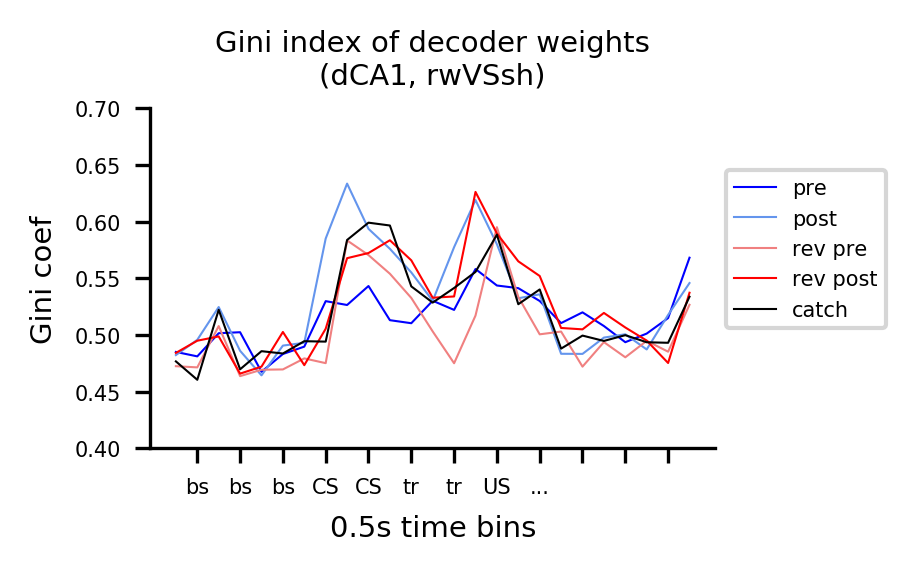

In [15]:
comparison = 'rwVSsh'
pl.plot(eval("gini_coef_%s"%comparison)['pre'],color='b')
pl.plot(eval("gini_coef_%s"%comparison)['post'],color='cornflowerblue')
pl.plot(eval("gini_coef_%s"%comparison)['pre_rev'],color='lightcoral')
pl.plot(eval("gini_coef_%s"%comparison)['post_rev'],color='r')
pl.plot(eval("gini_coef_%s"%comparison)['catch'],color='k')
pl.ylabel('Gini coef')
pl.xlabel('0.5s time bins')
pl.xticks(range(1,25,2),['bs','bs','bs','CS','CS','tr','tr','US','...'])
pl.legend(['pre','post','rev pre','rev post','catch'],loc='best', bbox_to_anchor=(1, 0.85))
pl.title('Gini index of decoder weights\n(dCA1, '+comparison+')')
pl.ylim(.4,.7)

pl.savefig("../img/%s_Gini_%s.jpg"%(NOTEBOOK_NAME,comparison))

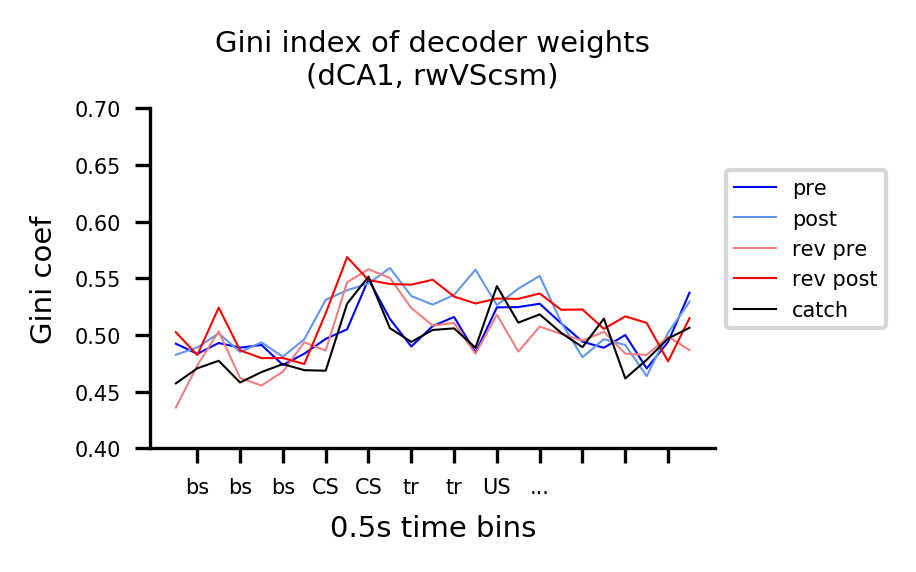

In [33]:
comparison = 'rwVScsm'
pl.plot(eval("gini_coef_%s"%comparison)['pre'],color='b')
pl.plot(eval("gini_coef_%s"%comparison)['post'],color='cornflowerblue')
pl.plot(eval("gini_coef_%s"%comparison)['pre_rev'],color='lightcoral')
pl.plot(eval("gini_coef_%s"%comparison)['post_rev'],color='r')
pl.plot(eval("gini_coef_%s"%comparison)['catch'],color='k')
pl.ylabel('Gini coef')
pl.xlabel('0.5s time bins')
pl.xticks(range(1,25,2),['bs','bs','bs','CS','CS','tr','tr','US','...'])
pl.legend(['pre','post','rev pre','rev post','catch'],loc='best', bbox_to_anchor=(1, 0.85))
pl.title('Gini index of decoder weights\n(dCA1, '+comparison+')')
pl.ylim(.4,.7)

pl.savefig("../img/%s_Gini_%s.jpg"%(NOTEBOOK_NAME,comparison))

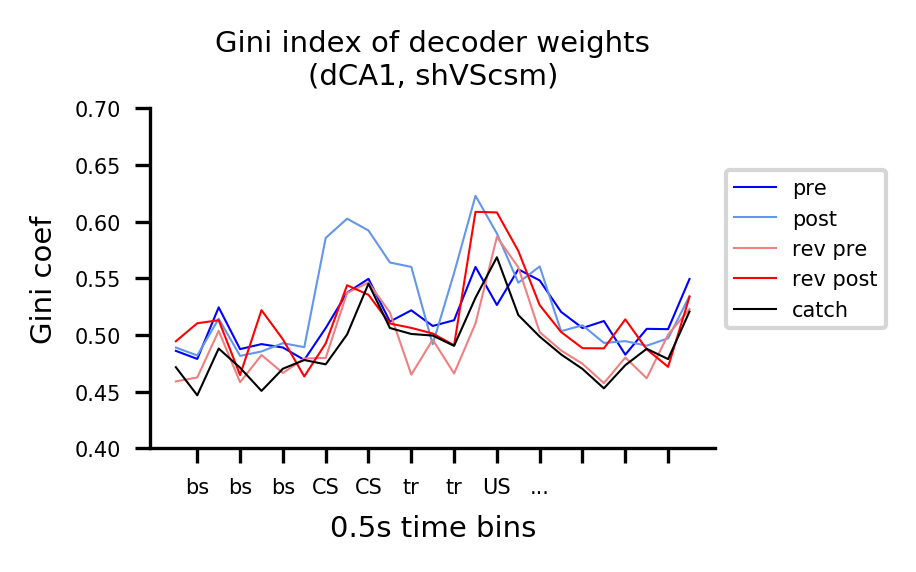

In [34]:
comparison = 'shVScsm'
pl.plot(eval("gini_coef_%s"%comparison)['pre'],color='b')
pl.plot(eval("gini_coef_%s"%comparison)['post'],color='cornflowerblue')
pl.plot(eval("gini_coef_%s"%comparison)['pre_rev'],color='lightcoral')
pl.plot(eval("gini_coef_%s"%comparison)['post_rev'],color='r')
pl.plot(eval("gini_coef_%s"%comparison)['catch'],color='k')
pl.ylabel('Gini coef')
pl.xlabel('0.5s time bins')
pl.xticks(range(1,25,2),['bs','bs','bs','CS','CS','tr','tr','US','...'])
pl.legend(['pre','post','rev pre','rev post','catch'],loc='best', bbox_to_anchor=(1, 0.85))
pl.title('Gini index of decoder weights\n(dCA1, '+comparison+')')
pl.ylim(.4,.7)

pl.savefig("../img/%s_Gini_%s.jpg"%(NOTEBOOK_NAME,comparison))

In [35]:
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for sess in sessions:
        exec("weight_matrix_%s_%s = []"%(vs,sess))
        exec("abs_weight_matrix_%s_%s = []"%(vs,sess)) #for absolute values
        for tb in reference_tbs:
            exec("weight_matrix_%s_%s.append(avg_weights_%s_tb_%s[sess])"%(vs,sess,vs,tb))
            exec("abs_weight_matrix_%s_%s.append(abs_avg_weights_%s_tb_%s[sess])"%(vs,sess,vs,tb))
        exec("weight_matrix_%s_%s_trans = np.array(weight_matrix_%s_%s).T"%(vs,sess, vs,sess))
        exec("abs_weight_matrix_%s_%s_trans = np.array(abs_weight_matrix_%s_%s).T"%(vs,sess, vs,sess))

In [36]:
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for tb in reference_tbs:
        exec("max_norm_avg_weights_%s_tb_%s = {}"%(vs,tb))
        for sess in sessions:
            exec("max_norm_avg_weights_%s_tb_%s[sess]=[]"%(vs,tb))
            for i,x in zip(eval("avg_weights_%s_tb_%s[sess]"%(vs,tb)),range(len(eval("avg_weights_%s_tb_%s[sess]"%(vs,tb))))):
                eval("max_norm_avg_weights_%s_tb_%s[sess]"%(vs,tb)).insert(x,float(abs(i))/max(abs(np.array(eval("avg_weights_%s_tb_%s[sess]"%(vs,tb))))))

In [37]:
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for tb in reference_tbs:
        exec("sum_norm_avg_weights_%s_tb_%s = {}"%(vs,tb))
        for sess in sessions:
            exec("sum_norm_avg_weights_%s_tb_%s[sess]=[]"%(vs,tb))
            for i,x in zip(eval("avg_weights_%s_tb_%s[sess]"%(vs,tb)),range(len(eval("avg_weights_%s_tb_%s[sess]"%(vs,tb))))):
                eval("sum_norm_avg_weights_%s_tb_%s[sess]"%(vs,tb)).insert(x,float(abs(i))/sum(abs(np.array(eval("avg_weights_%s_tb_%s[sess]"%(vs,tb))))))

In [38]:
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for sess in sessions:
        exec("max_norm_weight_matrix_%s_%s = []"%(vs,sess))
        exec("sum_norm_weight_matrix_%s_%s = []"%(vs,sess))
        for tb in reference_tbs:
            exec("max_norm_weight_matrix_%s_%s.append(max_norm_avg_weights_%s_tb_%s[sess])"%(vs,sess,vs,tb))
            exec("sum_norm_weight_matrix_%s_%s.append(sum_norm_avg_weights_%s_tb_%s[sess])"%(vs,sess,vs,tb))
        
        indices = np.argsort(eval("max_norm_weight_matrix_%s_%s[0]"%(vs,sess))) #get order of indices when sorting data from first tb
        exec("sorted_max_norm_weight_matrix_%s_%s =[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]"%(vs,sess))
        for t in range(len(eval("max_norm_weight_matrix_%s_%s"%(vs,sess)))):
            for x in indices[::-1]:  #reverse to get descending order
                exec("sorted_max_norm_weight_matrix_%s_%s[t].append(max_norm_weight_matrix_%s_%s[t][x])"%(vs,sess,vs,sess))
        
        indices = np.argsort(eval("sum_norm_weight_matrix_%s_%s[0]"%(vs,sess))) #get order of indices when sorting data from first tb
        exec("sorted_sum_norm_weight_matrix_%s_%s =[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]"%(vs,sess))
        for t in range(len(eval("sum_norm_weight_matrix_%s_%s"%(vs,sess)))):
            for x in indices[::-1]:
                exec("sorted_sum_norm_weight_matrix_%s_%s[t].append(sum_norm_weight_matrix_%s_%s[t][x])"%(vs,sess,vs,sess))
                
        exec("max_norm_weight_matrix_%s_%s_trans = np.array(max_norm_weight_matrix_%s_%s).T"%(vs,sess, vs,sess))
        exec("sum_norm_weight_matrix_%s_%s_trans = np.array(sum_norm_weight_matrix_%s_%s).T"%(vs,sess, vs,sess))
        exec("sorted_max_norm_weight_matrix_%s_%s_trans = np.array(sorted_max_norm_weight_matrix_%s_%s).T"%(vs,sess,vs,sess))
        exec("sorted_sum_norm_weight_matrix_%s_%s_trans = np.array(sorted_sum_norm_weight_matrix_%s_%s).T"%(vs,sess,vs,sess))

In [39]:
#now gonna try and sort cells into time bins with max activity (then sort cells w/in specific tb in ascending order)
#first find tb for which each cell is maximially active
from operator import itemgetter

def max_val(l, i):
    return max(enumerate(map(itemgetter(i), l)),key=itemgetter(1))

for vs in 'rwVScsm','shVScsm','rwVSsh':
    for sess in sessions:
        exec("max_%s_tb_%s = []"%(vs,sess))
        for i in range(len(eval("abs_weight_matrix_%s_%s[0]"%(vs,sess)))):
            eval("max_%s_tb_%s"%(vs,sess)).insert(i,max_val(eval("abs_weight_matrix_%s_%s"%(vs,sess)),i))
        
#next, sort by tb, getting old index for cell ordering of other time bins
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for sess in sessions:
        eval("max_%s_tb_%s"%(vs,sess)).sort(key=itemgetter(1),reverse=True) #first sort by weight value in decending order
        eval("max_%s_tb_%s"%(vs,sess)).sort(key=itemgetter(0)) #sort by tb to get list sorted by ascending tb and descending weight w/in a tb

In [40]:
#need to use method to sort if duplicate values.
#I suppose I could just use this method (vs cell below) for all sessions...so I will

for vs in 'rwVScsm','shVScsm','rwVSsh':
    for sess in sessions:
        exec("sort_index_%s_%s=[]"%(vs,sess))
        for x in eval("max_%s_tb_%s"%(vs,sess)):
            exec("sort_index_%s_%s.append(abs_weight_matrix_%s_%s[x[0]].index(x[1]))"%(vs,sess,vs,sess))
        exec("sort_index_%s_%s=[]"%(vs,sess))
        for x in eval("max_%s_tb_%s"%(vs,sess)):
            exec("sort_index_%s_%s.append(abs_weight_matrix_%s_%s[x[0]].index(x[1]))"%(vs,sess,vs,sess))

In [41]:
#for vs in 'rwVScsm','shVScsm','rwVSsh':
#    for sess in sessions:
#        exec("sort_index_%s_%s = []"%(vs,sess))
#        for x in eval("max_%s_tb_%s"%(vs,sess)):
#            for i, j in enumerate(eval("abs_weight_matrix_%s_%s"%(vs,sess))[x[0]]):
#                if j == x[1]:
#                    exec("sort_index_%s_%s.append(i)"%(vs,sess))

In [42]:
#check that sorted cell number matches the total number of cells
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for sess in sessions:
        print vs,sess,": ",len(eval("abs_weight_matrix_%s_%s[5]"%(vs,sess))), len(eval("sort_index_%s_%s"%(vs,sess)))

rwVScsm pre :  569 569
rwVScsm post :  676 676
rwVScsm pre_rev :  565 565
rwVScsm post_rev :  639 639
rwVScsm catch :  609 609
shVScsm pre :  569 569
shVScsm post :  676 676
shVScsm pre_rev :  565 565
shVScsm post_rev :  639 639
shVScsm catch :  609 609
rwVSsh pre :  569 569
rwVSsh post :  676 676
rwVSsh pre_rev :  565 565
rwVSsh post_rev :  639 639
rwVSsh catch :  609 609


In [43]:
#now sort each tb by sort_index
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for sess in sessions:
        exec("tb_sorted_weight_matrix_%s_%s =[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]"%(vs,sess))
        for t in range(len(eval("abs_weight_matrix_%s_%s"%(vs,sess)))):
            for x in eval("sort_index_%s_%s"%(vs,sess)):
                exec("tb_sorted_weight_matrix_%s_%s[t].append(abs_weight_matrix_%s_%s[t][x])"%(vs,sess,vs,sess))
                exec("tb_sorted_weight_matrix_%s_%s_trans = np.array(tb_sorted_weight_matrix_%s_%s).T"%(vs,sess,vs,sess))

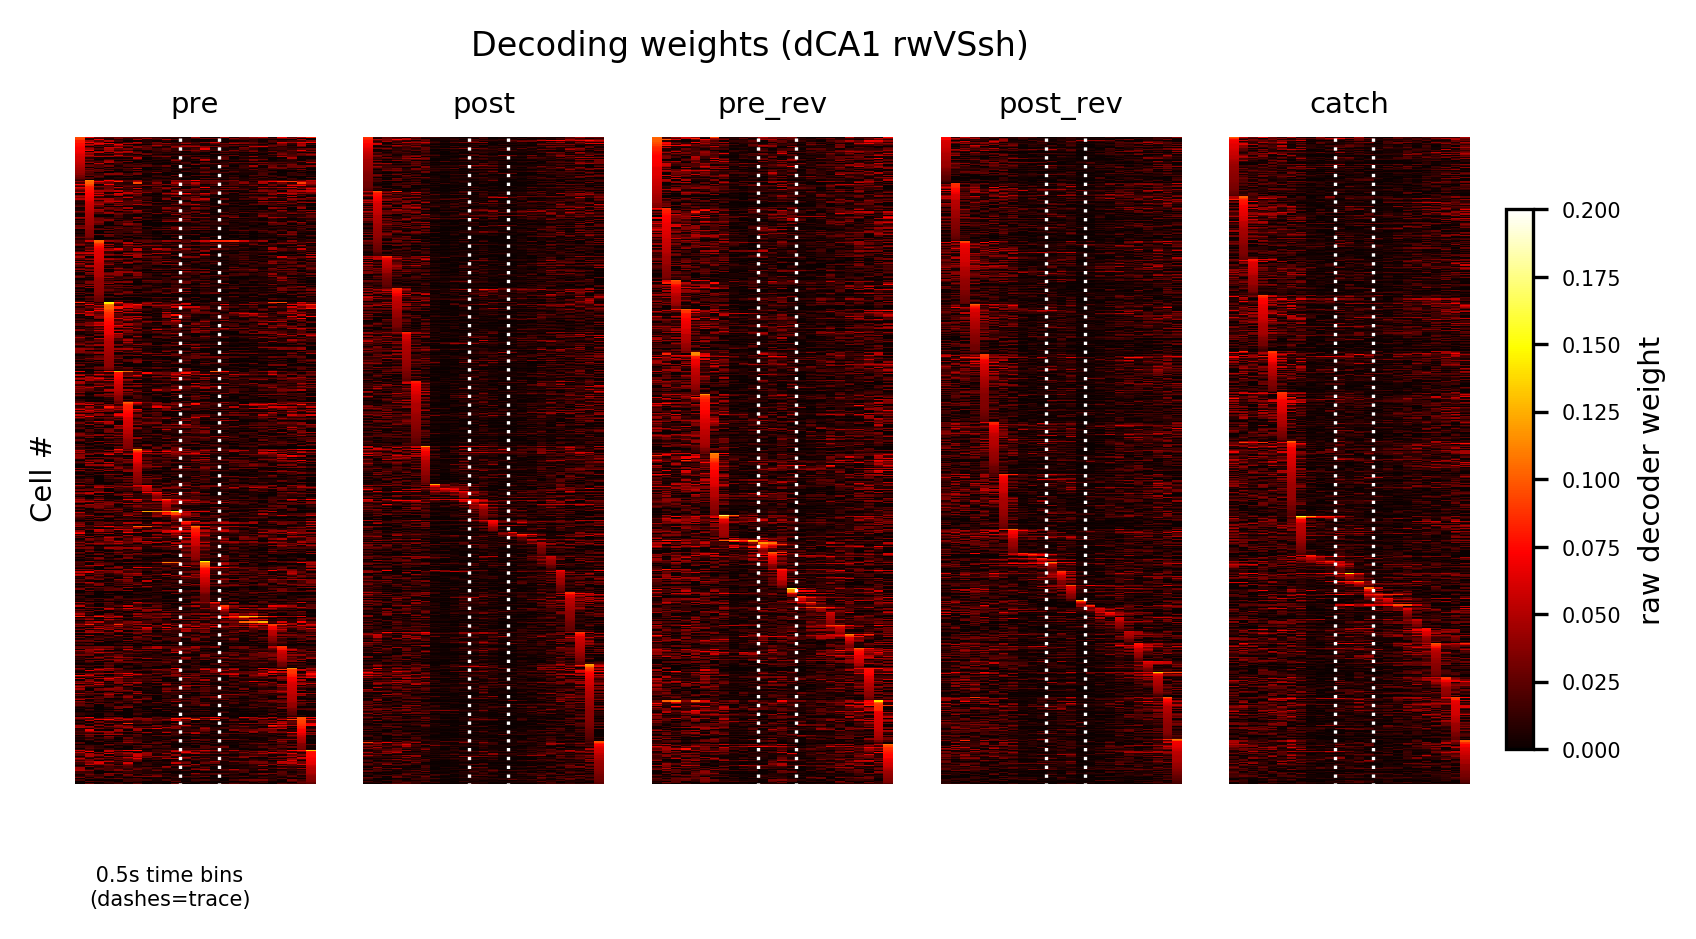

In [16]:
comparison='rwVSsh'
fig,axs = pl.subplots(1,5,figsize=(6,3))
for sess,c in zip(sessions,range(len(sessions))):
        im=axs[c].imshow(eval("tb_sorted_weight_matrix_%s_%s_trans"%(comparison,sess)),vmin=.0,vmax=.2, aspect='auto',cmap='hot')
        axs[c].set_title(sess,fontsize=7)
        axs[c].vlines(10.5,0,len(eval("tb_sorted_weight_matrix_%s_%s_trans"%(comparison,sess))),color='w',linestyle=':',linewidths=.8)
        axs[c].vlines(14.5,0,len(eval("tb_sorted_weight_matrix_%s_%s_trans"%(comparison,sess))),color='w',linestyle=':',linewidths=.8)
        pt.remove_axes(axs[c])
axs[0].text(1,675,' 0.5s time bins\n(dashes=trace)')
axs[0].set_ylabel('Cell #')
pl.suptitle('Decoding weights (dCA1 '+comparison+')',y=1,fontsize=8)
cax = fig.add_axes([.92, 0.2, 0.015, .6])
cbar=pl.colorbar(im,cax=cax)
cbar.set_label('raw decoder weight')
#
#fig.tight_layout()
fig.savefig("../img/%s_TBsort_raw_heatmap_%s.jpg"%(NOTEBOOK_NAME,comparison))


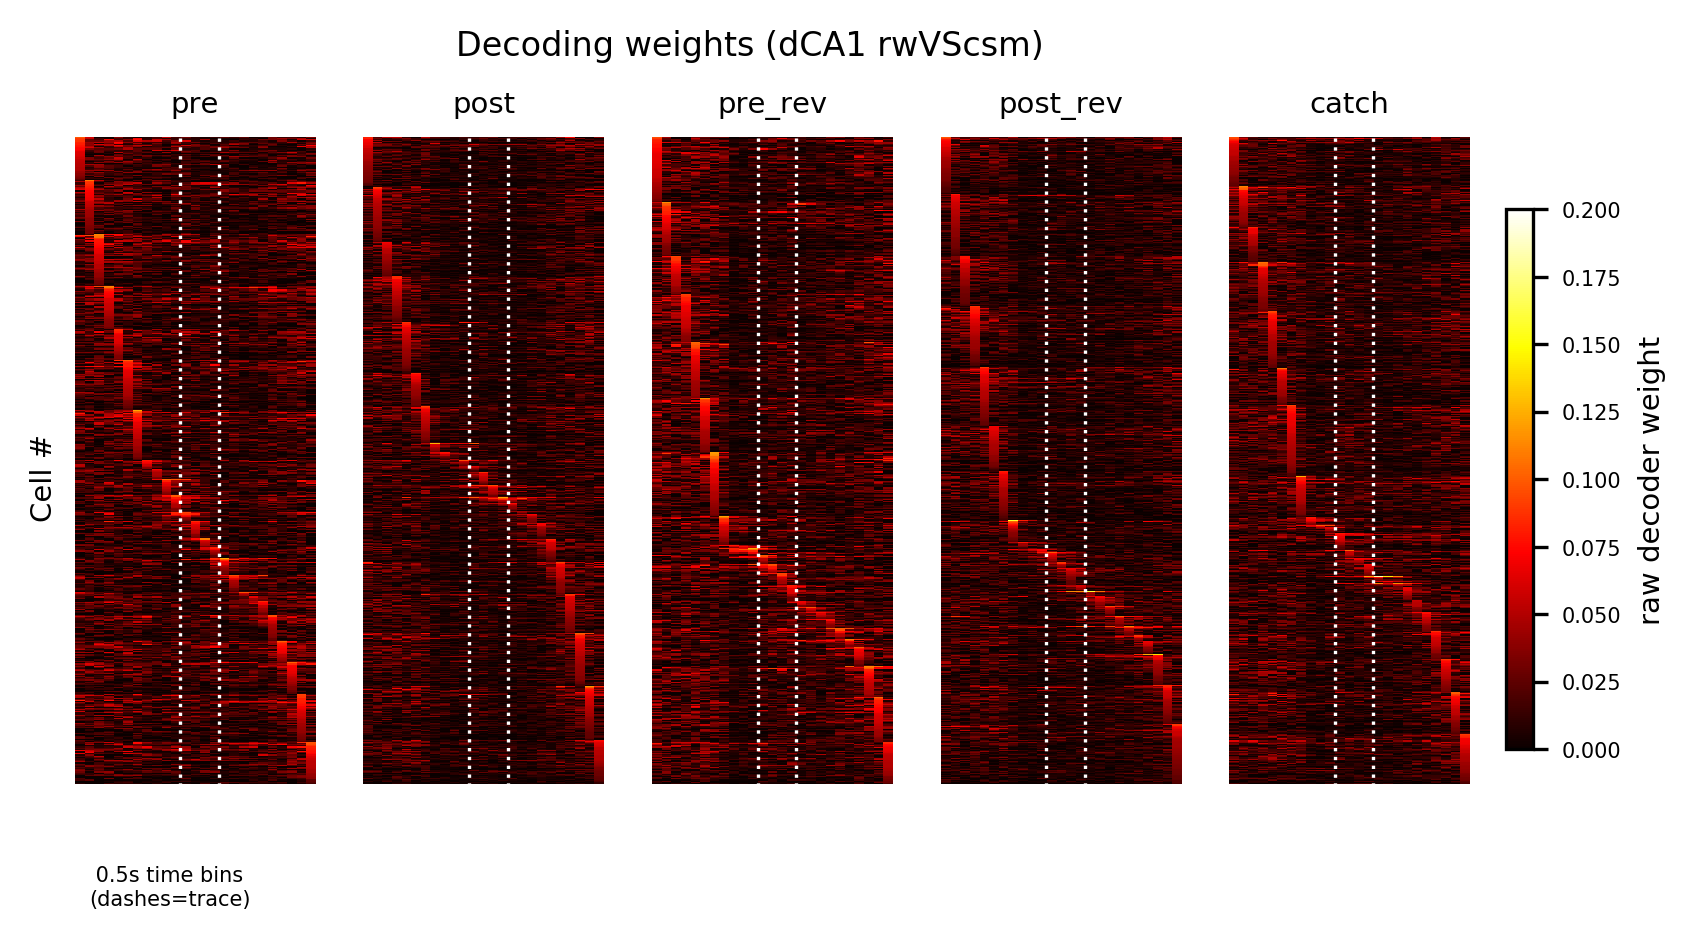

In [45]:
comparison='rwVScsm'
fig,axs = pl.subplots(1,5,figsize=(6,3))
for sess,c in zip(sessions,range(len(sessions))):
        im=axs[c].imshow(eval("tb_sorted_weight_matrix_%s_%s_trans"%(comparison,sess)),vmin=.0,vmax=.2, aspect='auto',cmap='hot')
        axs[c].set_title(sess,fontsize=7)
        axs[c].vlines(10.5,0,len(eval("tb_sorted_weight_matrix_%s_%s_trans"%(comparison,sess))),color='w',linestyle=':',linewidths=.8)
        axs[c].vlines(14.5,0,len(eval("tb_sorted_weight_matrix_%s_%s_trans"%(comparison,sess))),color='w',linestyle=':',linewidths=.8)
        pt.remove_axes(axs[c])
axs[0].text(1,675,' 0.5s time bins\n(dashes=trace)')
axs[0].set_ylabel('Cell #')
pl.suptitle('Decoding weights (dCA1 '+comparison+')',y=1,fontsize=8)
cax = fig.add_axes([.92, 0.2, 0.015, .6])
cbar=pl.colorbar(im,cax=cax)
cbar.set_label('raw decoder weight')
#
#fig.tight_layout()
fig.savefig("../img/%s_TBsort_raw_heatmap_%s.jpg"%(NOTEBOOK_NAME,comparison))


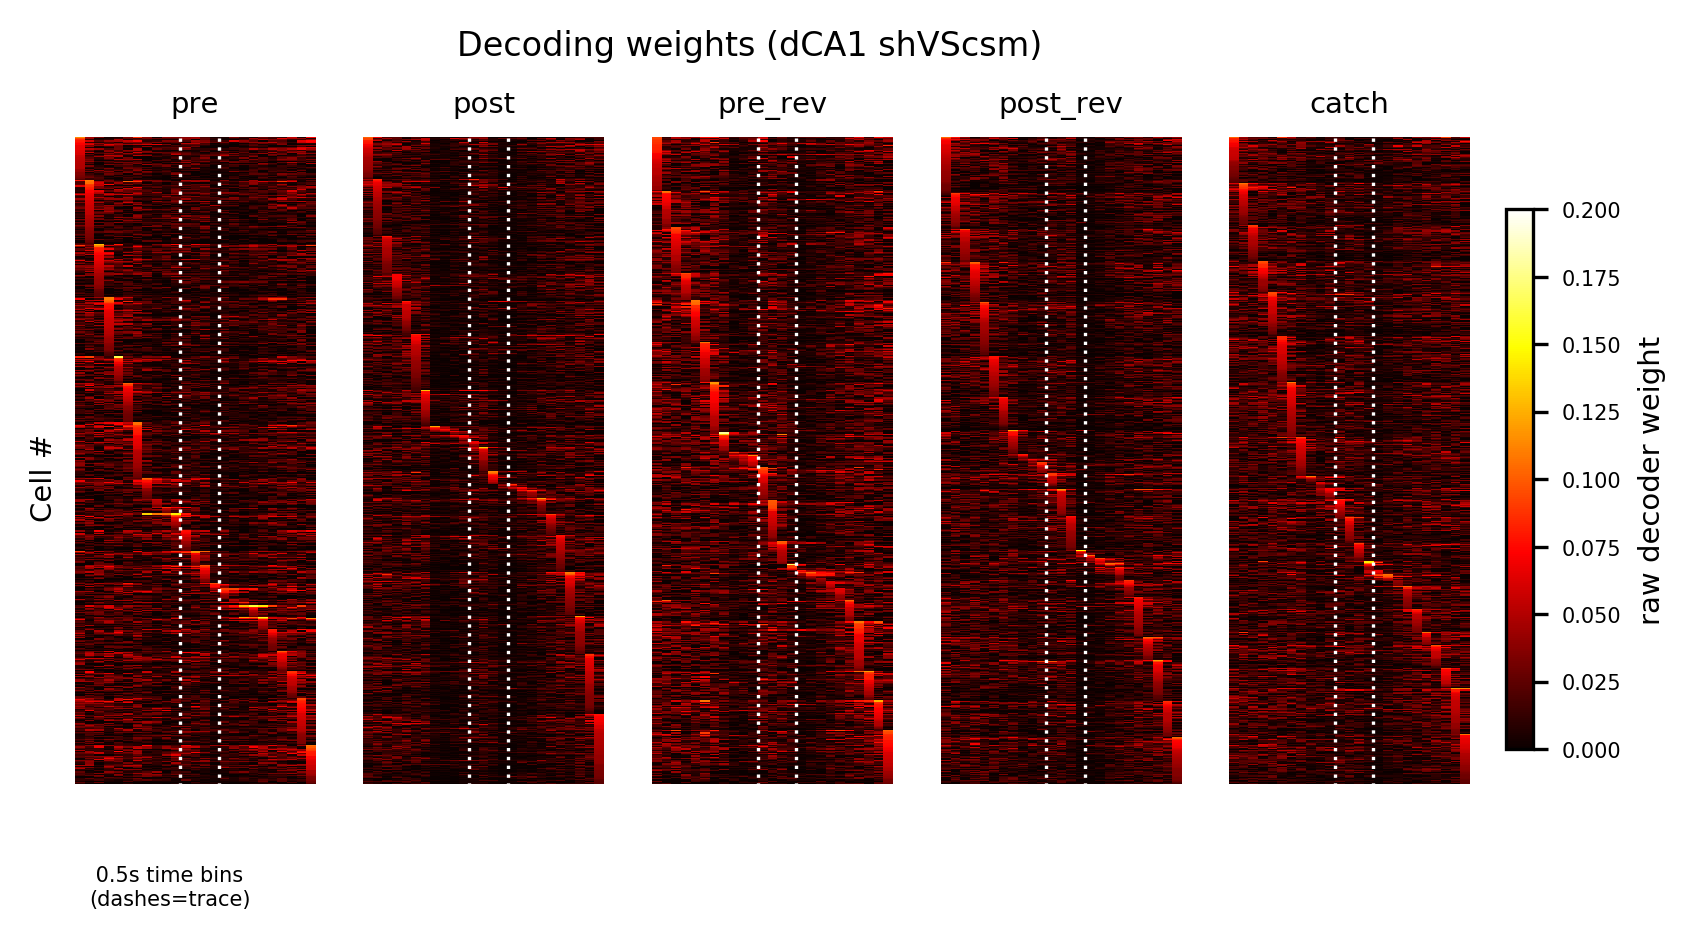

In [46]:
comparison='shVScsm'
fig,axs = pl.subplots(1,5,figsize=(6,3))
for sess,c in zip(sessions,range(len(sessions))):
        im=axs[c].imshow(eval("tb_sorted_weight_matrix_%s_%s_trans"%(comparison,sess)),vmin=.0,vmax=.2, aspect='auto',cmap='hot')
        axs[c].set_title(sess,fontsize=7)
        axs[c].vlines(10.5,0,len(eval("tb_sorted_weight_matrix_%s_%s_trans"%(comparison,sess))),color='w',linestyle=':',linewidths=.8)
        axs[c].vlines(14.5,0,len(eval("tb_sorted_weight_matrix_%s_%s_trans"%(comparison,sess))),color='w',linestyle=':',linewidths=.8)
        pt.remove_axes(axs[c])
axs[0].text(1,675,' 0.5s time bins\n(dashes=trace)')
axs[0].set_ylabel('Cell #')
pl.suptitle('Decoding weights (dCA1 '+comparison+')',y=1,fontsize=8)
cax = fig.add_axes([.92, 0.2, 0.015, .6])
cbar=pl.colorbar(im,cax=cax)
cbar.set_label('raw decoder weight')
#
#fig.tight_layout()
fig.savefig("../img/%s_TBsort_raw_heatmap_%s.jpg"%(NOTEBOOK_NAME,comparison))


## first take random cells and decode

In [47]:
%%time
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for t in range(25): # number of time bins
        exec('random_cells_scores_%s_tb_%s = {}'%(vs,t))
        n_loops = 30
        for sess in sessions:
            print sess,t,vs,
            eval("random_cells_scores_%s_tb_%s"%(vs,t))[sess] = np.r_[[do_test_within(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s_%s'%(vs,sess)),n_cells=30) for i in range(n_loops)]]

pre 0 rwVScsm post 0 rwVScsm pre_rev 0 rwVScsm post_rev 0 rwVScsm catch 0 rwVScsm pre 1 rwVScsm post 1 rwVScsm pre_rev 1 rwVScsm post_rev 1 rwVScsm catch 1 rwVScsm pre 2 rwVScsm post 2 rwVScsm pre_rev 2 rwVScsm post_rev 2 rwVScsm catch 2 rwVScsm pre 3 rwVScsm post 3 rwVScsm pre_rev 3 rwVScsm post_rev 3 rwVScsm catch 3 rwVScsm pre 4 rwVScsm post 4 rwVScsm pre_rev 4 rwVScsm post_rev 4 rwVScsm catch 4 rwVScsm pre 5 rwVScsm post 5 rwVScsm pre_rev 5 rwVScsm post_rev 5 rwVScsm catch 5 rwVScsm pre 6 rwVScsm post 6 rwVScsm pre_rev 6 rwVScsm post_rev 6 rwVScsm catch 6 rwVScsm pre 7 rwVScsm post 7 rwVScsm pre_rev 7 rwVScsm post_rev 7 rwVScsm catch 7 rwVScsm pre 8 rwVScsm post 8 rwVScsm pre_rev 8 rwVScsm post_rev 8 rwVScsm catch 8 rwVScsm pre 9 rwVScsm post 9 rwVScsm pre_rev 9 rwVScsm post_rev 9 rwVScsm catch 9 rwVScsm pre 10 rwVScsm post 10 rwVScsm pre_rev 10 rwVScsm post_rev 10 rwVScsm catch 10 rwVScsm pre 11 rwVScsm post 11 rwVScsm pre_rev 11 rwVScsm post_rev 11 rwVScsm catch 11 rwVScsm pre 12

In [17]:
def plot_scores(scores,col,last_plot,bins=25):
    colors=['cornflowerblue','b','lightcoral','r','k']
    for t in range(bins):
        scoresP = eval("%s_%s"%(scores,t))
        for sess,r in zip(sessions,range(len(sessions))):
            ax[col][r].plot((t/2.0)-2.75, np.mean(scoresP[sess])*100, 'o', color=colors[r], ls='-',lw=.5, zorder=19 ,ms=1)
            m = np.mean(scoresP[sess])*100
            s = np.std(scoresP[sess])*100 / np.sqrt(scoresP[sess].shape[-1])
            ax[col][r].errorbar((t/2.0)-2.75, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
    
    for x in range (0,5):
        ax[0][0].set_ylim(0, 100)
        ax[0][0].set_xlim(-3.5, 9)
        ax[0][0].set_xticks(np.arange(-3,9, 1))
        ax[0][0].set_xticklabels(np.arange(-3,9, 1))
        for y in range(2):
            pt.plot_period_bar(ax[y][x], 25, start_end=(0, 2), color='r', delta_y=3)
            pt.plot_period_bar(ax[y][x], 25, start_end=(4, 4.2), color='b', delta_y=3)
            ax[y][x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
            ax[y][x].hlines(50, -6,11, color='k', lw=1, linestyles='dotted')
            #ax[y][x].vlines(reference_tb/2.0-4.25,0,100,color='r',lw=0.5,linestyles='--')
        ax[0][0].set_ylabel('Performance %\n(all cells)')
        ax[0][0].set_title('early',fontsize=8)
        ax[0][1].set_title('late',fontsize=8)
        ax[0][2].set_title('rev early',fontsize=8)
        ax[0][3].set_title('rev late',fontsize=8)
        ax[0][4].set_title('catch',fontsize=8)
        fig.tight_layout(pad=3)
    
    if last_plot == True:
        ax[col][x].set_xlabel('Time from odor onset (s)',fontsize=6)
        ax[col][0].set_ylabel('ax[x][0].set_ylabel("title")')

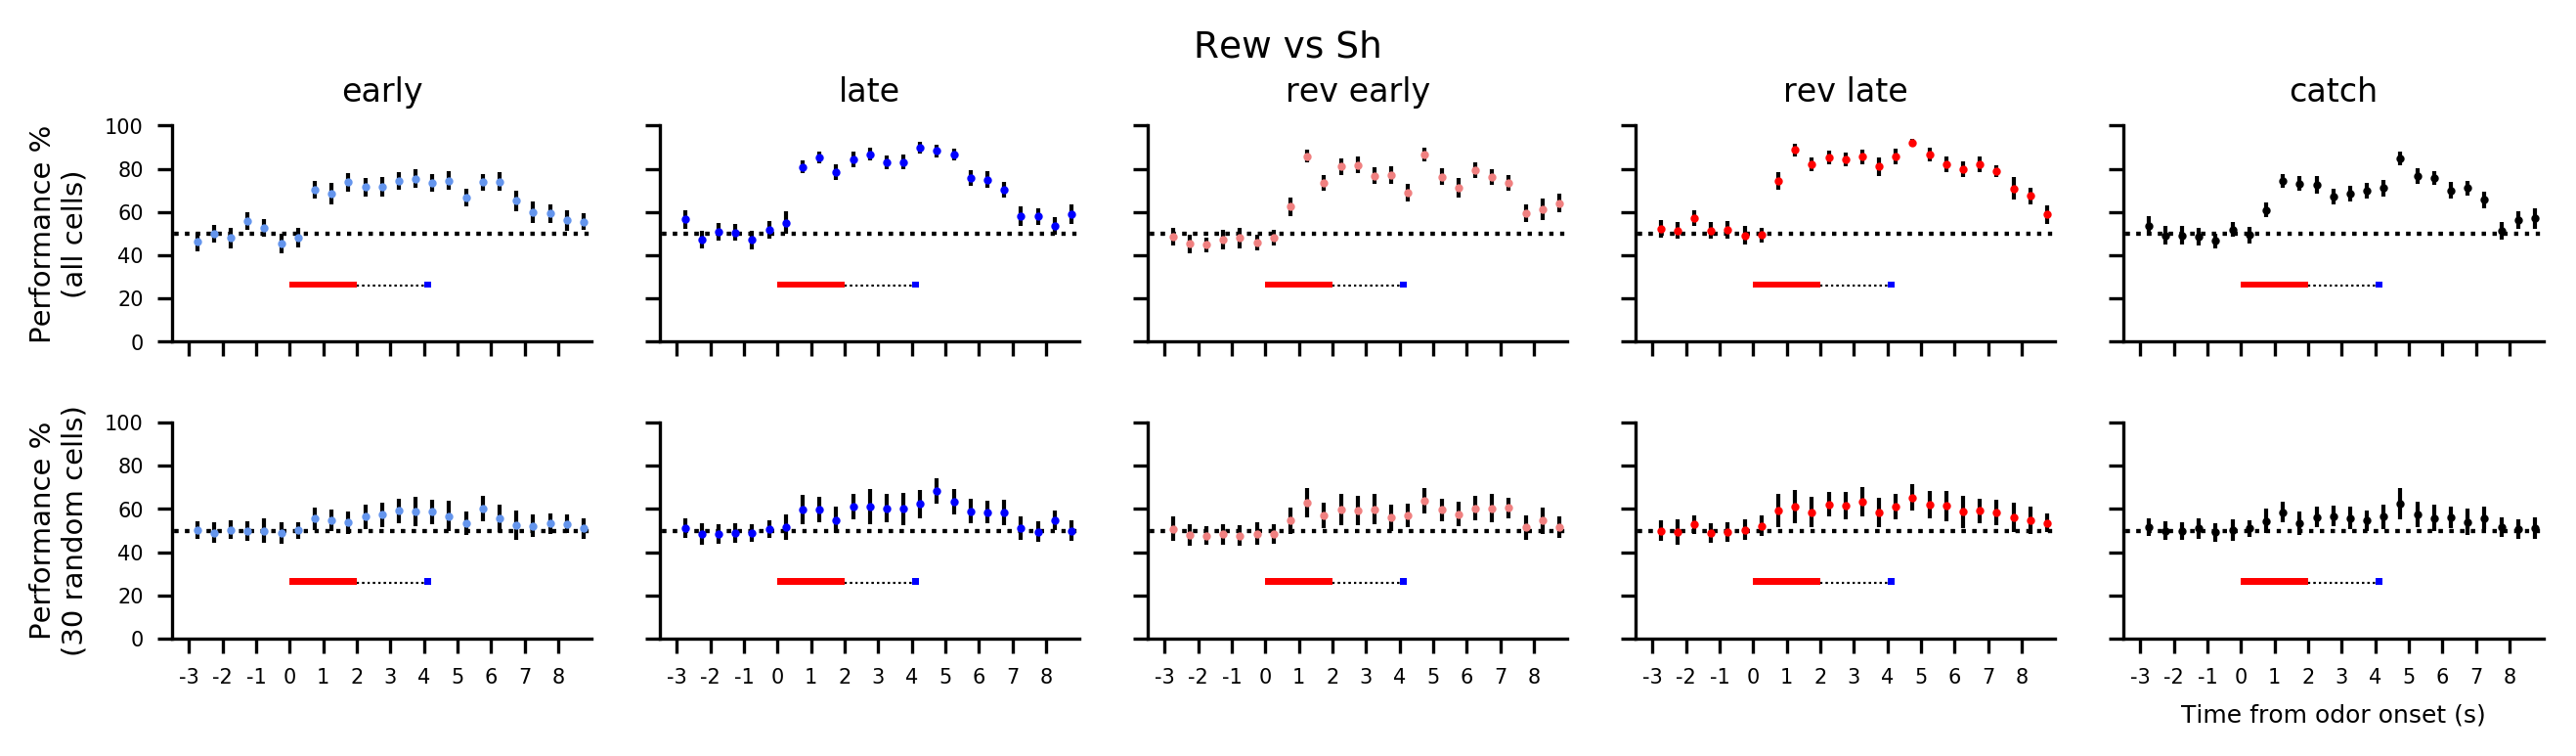

In [18]:
fig, ax = pl.subplots(2,5, figsize=(9, 2.5),sharex=True, sharey=True)

plot_scores('scores_rwVScsm_tb',0,False)
plot_scores('random_cells_scores_rwVScsm_tb',1,True)

ax[1][0].set_ylabel('Performance %\n(30 random cells)')
pl.suptitle('Rew vs CS-',fontsize=9)

#fig.savefig('../img/%s_horizontal_tb_%s.jpg'%(NOTEBOOK_NAME,reference_tb))

## take top cells using absolute value

In [19]:
#find index of cells with decoder weights, percentile, or top no. of cells above some threshold
weight_thresh = 0.01
percentile_thresh = 90
top_cells=30

for vs in 'rwVScsm','shVScsm','rwVSsh':
    for sess in sessions:
        for tb in reference_tbs:
            exec("cells_%s_%s_%s_top_abs = []"%(vs,sess,tb))
            exec("cells_thresh_%s_%s_%s = sorted(range(len(abs_avg_weights_%s_tb_%s[sess])),\
                                    key=lambda i: abs_avg_weights_%s_tb_%s[sess][i],reverse=True)[:top_cells]"%(vs,sess,tb,vs,tb,vs,tb))
            exec("cells_%s_%s_%s_top_abs = cells_thresh_%s_%s_%s[:]"%(vs,sess,tb,vs,sess,tb))
    for sess in sessions:
        for tb in reference_tbs:
            exec("cells_%s_%s_%s_percentile_abs = []"%(vs,sess,tb))
            for idx in range(0, eval("len(abs_avg_weights_%s_tb_%s[sess])"%(vs,tb))): 
                if eval("abs_avg_weights_%s_tb_%s[sess][idx]"%(vs,tb)) > np.percentile(eval("abs_avg_weights_%s_tb_%s[sess]"%(vs,tb)),percentile_thresh):
                    exec("cells_%s_%s_%s_percentile_abs.append(idx)"%(vs,sess,tb))
    for sess in sessions:
        for tb in reference_tbs:
            exec("cells_%s_%s_%s_weight_abs = []"%(vs,sess,tb))
            for idx in range(0, eval("len(abs_avg_weights_%s_tb_%s[sess])"%(vs,tb))): 
                if eval("abs_avg_weights_%s_tb_%s[sess][idx]"%(vs,tb)) > weight_thresh:
                    exec("cells_%s_%s_%s_weight_abs.append(idx)"%(vs,sess,tb))

In [ ]:
%%time
###GOT STUCK ON POST_REV 9 FOR rwVSsh ###############
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for t in range(25): # number of time bins
        for tb in reference_tbs:
            for threshold_method in 'top_abs','percentile_abs','weight_abs':
                exec('subset_scores_%s_tb_%s_%s_%s = {}'%(vs,t,tb,threshold_method))
                n_loops = 30
                for sess in sessions:
                    exec("cells = cells_%s_%s_%s_%s"%(vs,sess,tb,threshold_method))
                    print sess,t,
                    eval("subset_scores_%s_tb_%s_%s_%s"%(vs,t,tb,threshold_method))[sess] = np.r_[[do_test_within_subset(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s_%s'%(vs,sess)),cells) for i in range(n_loops)]]

In [27]:
#bottom25_percentile_thresh = 25
bottom15_percentile_thresh = 15
top_20 = 20
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for sess in sessions:
        for tb in reference_tbs:
            exec("cells_%s_%s_%s_bottom25_abs = []"%(vs,sess,tb))
            for idx in range(0, eval("len(abs_avg_weights_%s_tb_%s[sess])"%(vs,tb))): 
                if eval("abs_avg_weights_%s_tb_%s[sess][idx]"%(vs,tb)) <= np.percentile(eval("abs_avg_weights_%s_tb_%s[sess]"%(vs,tb)),bottom25_percentile_thresh):
                    exec("cells_%s_%s_%s_bottom25_abs.append(idx)"%(vs,sess,tb))
    for sess in sessions:
        for tb in reference_tbs:
            exec("cells_%s_%s_%s_bottom15_abs = []"%(vs,sess,tb))
            for idx in range(0, eval("len(abs_avg_weights_%s_tb_%s[sess])"%(vs,tb))): 
                if eval("abs_avg_weights_%s_tb_%s[sess][idx]"%(vs,tb)) <= np.percentile(eval("abs_avg_weights_%s_tb_%s[sess]"%(vs,tb)),bottom15_percentile_thresh):
                    exec("cells_%s_%s_%s_bottom15_abs.append(idx)"%(vs,sess,tb))
    for sess in sessions:
        for tb in reference_tbs:
            exec("cells_%s_%s_%s_top_20_abs = []"%(vs,sess,tb))
            exec("cells_thresh_%s_%s_%s = sorted(range(len(abs_avg_weights_%s_tb_%s[sess])),\
                                    key=lambda i: abs_avg_weights_%s_tb_%s[sess][i],reverse=True)[:top_20]"%(vs,sess,tb,vs,tb,vs,tb))
            exec("cells_%s_%s_%s_top_20_abs = cells_thresh_%s_%s_%s[:]"%(vs,sess,tb,vs,sess,tb))

In [ ]:
%%time
############STUCK ON CATCH 15 24 TOP rwVScsm####################3
for vs in 'rwVScsm','shVScsm','rwVSsh':
    for t in range(25): # number of time bins
        for tb in reference_tbs:
            for threshold_method in 'bottom15_abs','top_20_abs':
                exec('subset_scores_%s_tb_%s_%s_%s = {}'%(vs,t,tb,threshold_method))
                n_loops = 30
                for sess in sessions:
                    exec("cells = cells_%s_%s_%s_%s"%(vs,sess,tb,threshold_method))
                    print sess,t,tb,threshold_method[:3],"   ",
                    eval("subset_scores_%s_tb_%s_%s_%s"%(vs,t,tb,threshold_method))[sess] = np.r_[[do_test_within_subset(eval('patterns_tb_%s_%s'%(t,sess)),eval('labels_%s_%s'%(vs,sess)),cells) for i in range(n_loops)]]

pre 0 0 bot     post 0 0 bot     pre_rev 0 0 bot     post_rev 0 0 bot     catch 0 0 bot     pre 0 0 top     post 0 0 top     pre_rev 0 0 top     post_rev 0 0 top     catch 0 0 top     pre 0 1 bot     post 0 1 bot     pre_rev 0 1 bot     post_rev 0 1 bot     catch 0 1 bot     pre 0 1 top     post 0 1 top     pre_rev 0 1 top     post_rev 0 1 top     catch 0 1 top     pre 0 2 bot     post 0 2 bot     pre_rev 0 2 bot     post_rev 0 2 bot     catch 0 2 bot     pre 0 2 top     post 0 2 top     pre_rev 0 2 top     post_rev 0 2 top     catch 0 2 top     pre 0 3 bot     post 0 3 bot     pre_rev 0 3 bot     post_rev 0 3 bot     catch 0 3 bot     pre 0 3 top     post 0 3 top     pre_rev 0 3 top     post_rev 0 3 top     catch 0 3 top     pre 0 4 bot     post 0 4 bot     pre_rev 0 4 bot     post_rev 0 4 bot     catch 0 4 bot     pre 0 4 top     post 0 4 top     pre_rev 0 4 top     post_rev 0 4 top     catch 0 4 top     pre 0 5 bot     post 0 5 bot     pre_rev 0 5 bot     post_rev 0 5 bot     catch 

In [9]:
def plot_ref_scores(comparison,method,scores = 'subset_scores',ylabel='input ylabel variable',
                    all_cells_overlay=False,subset_cells_overlay=False):
    
    colors=['cornflowerblue','b','lightcoral','r','k']
    fig, ax = pl.subplots((len(reference_tbs)+2),5, figsize=(6, 22),sharex=True, sharey=True)
    
    #plot scores using all cells
    for t in range(25):
        for sess,r in zip(sessions,range(len(sessions))):
            ax[0][r].plot((t/2.0)-2.75, np.mean(eval("scores_%s_tb_%s[sess]"%(comparison,t)))*100, 'o', color=colors[r], ls='-',lw=.5, zorder=19 ,ms=1)
            m = np.mean(eval("scores_%s_tb_%s[sess]"%(comparison,t)))*100
            s = np.std(eval("scores_%s_tb_%s[sess]"%(comparison,t)))*100 / np.sqrt(eval("scores_%s_tb_%s[sess]"%(comparison,t)).shape[-1])
            ax[0][r].errorbar((t/2.0)-2.75, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
            
    #plot top scores at each reference tb for scores using subset of cells
    for tb in (reference_tbs):
        for sess,r in zip(sessions,range(len(sessions))):
            scoresP = eval("%s_%s_tb_%s_%s_%s"%(scores,comparison,tb,tb,method))
            ax[1][r].plot((tb/2.0)-2.75, np.mean(scoresP[sess])*100, 'o', color=colors[r], ls='-',lw=.5, zorder=19 ,ms=1)
            m = np.mean(scoresP[sess])*100
            s = np.std(scoresP[sess])*100 / np.sqrt(scoresP[sess].shape[-1])
            ax[1][r].errorbar((tb/2.0)-2.75, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
            if all_cells_overlay==True:
                ax[1][r].plot((tb/2.0)-2.75,np.mean(eval("scores_%s_tb_%s[sess]"%(comparison,tb)))*100, 'o', color='silver', ls='-',lw=.5, zorder=19 ,ms=1)
        
    #plot scores obtained from the subset of cells
    for tb,a in zip(reference_tbs,range(2,len(reference_tbs)+2)):
        for t in range(25):
            scoresP = eval("%s_%s_tb_%s_%s_%s"%(scores,comparison,t,tb,method))
            for sess,r in zip(sessions,range(len(sessions))):
                ax[a][r].plot((t/2.0)-2.75, np.mean(scoresP[sess])*100, 'o', color=colors[r], ls='-',lw=.5, zorder=19 ,ms=1)
                m = np.mean(scoresP[sess])*100
                s = np.std(scoresP[sess])*100 / np.sqrt(scoresP[sess].shape[-1])
                ax[a][r].errorbar((t/2.0)-2.75, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
                if all_cells_overlay==True:
                    ax[a][r].plot((t/2.0)-2.75,np.mean(eval("scores_%s_tb_%s[sess]"%(comparison,t)))*100, 'o', color='silver', ls='-',lw=.5, zorder=19 ,ms=1)
                if subset_cells_overlay==True:
                    scoresO = eval("%s_%s_tb_%s_%s_%s"%(scores,comparison,t,t,method))
                    ax[a][r].plot((t/2.0)-2.75,np.mean(scoresO[sess])*100, 'o', color='silver', ls='-',lw=.5, zorder=19 ,ms=1)    
                
    for x in range (0,5):
        ax[0][0].set_ylim(0, 100)
        ax[0][0].set_xlim(-3, 10)
        ax[0][0].set_xticks(np.arange(-3,10, 1))
        ax[0][0].set_xticklabels(np.arange(-3,10, 1))
        ax[0][x].set_xlabel('Time from odor onset (s)',fontsize=4)
        ax[len(reference_tbs)+1][x].set_xlabel('Time from odor onset (s)',fontsize=4)
    
        for y,tb in zip(range(0,len(reference_tbs)),reference_tbs):
            pt.plot_period_bar(ax[y][x], 25, start_end=(0, 2), color='r', delta_y=3)
            pt.plot_period_bar(ax[y][x], 25, start_end=(4, 4.2), color='b', delta_y=3)
            ax[y][x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
            ax[y][x].hlines(50, -3,9, color='k', lw=1, linestyles='dotted')
            ax[y][0].set_ylabel(ylabel,fontsize=4)
        for y,tb in zip(range(2,len(reference_tbs)+2),reference_tbs): #the above doesn't cover the last row
            ax[y][x].vlines(tb/2.0-2.75,0,100,color='r',lw=0.5,linestyles='--')
            pt.plot_period_bar(ax[y][x], 25, start_end=(0, 2), color='r', delta_y=3)
            pt.plot_period_bar(ax[y][x], 25, start_end=(4, 4.2), color='b', delta_y=3)
            ax[y][x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
            ax[y][x].hlines(50, -3,9, color='k', lw=1, linestyles='dotted')
            ax[y][0].set_ylabel(ylabel,fontsize=4)
    
    ax[0][0].set_ylabel('Performance %\n(all cells)',fontsize=4)
    ax[1][0].set_ylabel('BEST '+ylabel,fontsize=4)
    ax[0][0].set_title('early, '+comparison,fontsize=7)
    ax[0][1].set_title('late',fontsize=8)
    ax[0][2].set_title('rev early',fontsize=8)
    ax[0][3].set_title('rev late',fontsize=8)
    ax[0][4].set_title('catch',fontsize=8)
    #pl.suptitle(comparison)
    #pl.tight_layout#(pad=3)
    
    fig.savefig('../img/%s_horizontal_all_tbs_%s_%s.jpg'%(NOTEBOOK_NAME,comparison,method))

NameError: name 'subset_scores_rwVScsm_tb_0_0_top_abs' is not defined

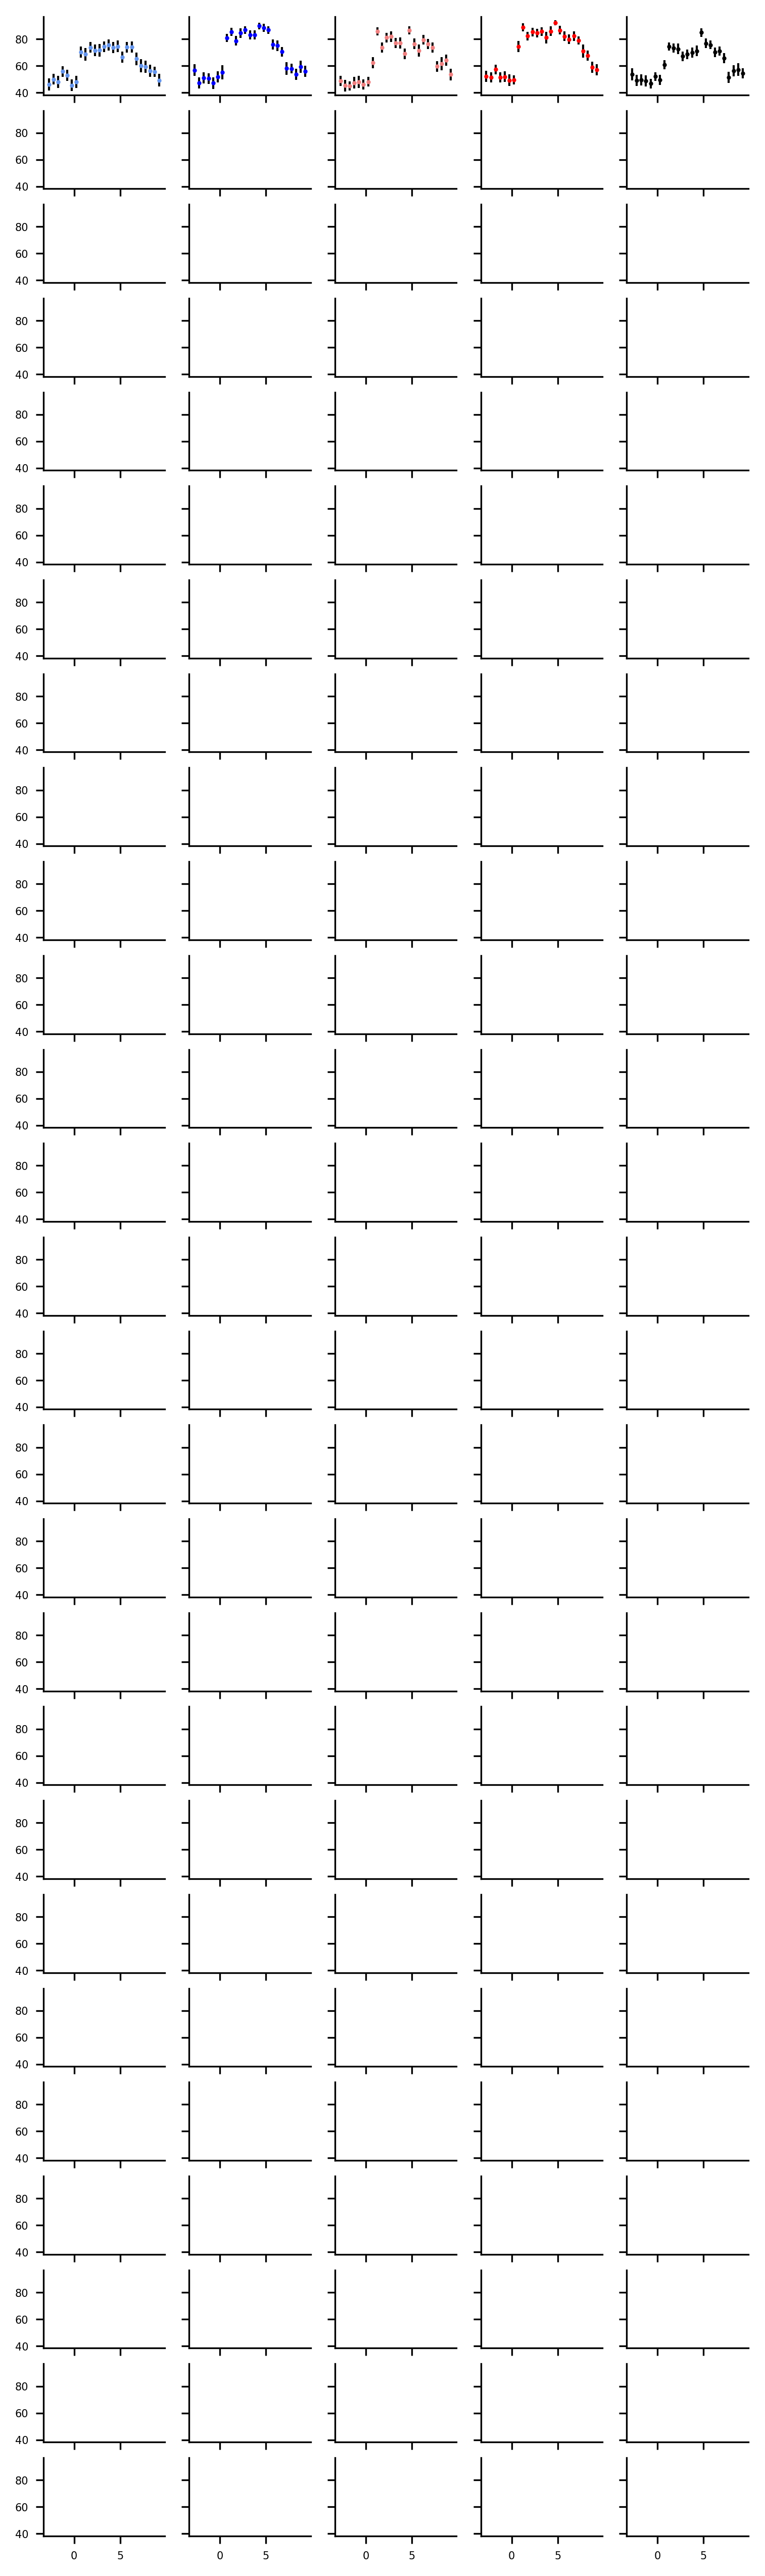

In [10]:
plot_ref_scores('rwVScsm','top_abs',ylabel='Perfromance\n(abs top 30 cells)',subset_cells_overlay=True)

In [ ]:
plot_ref_scores('rwVScsm','bottom15_abs',ylabel='Perfromance\n(abs >15th %ile)',subset_cells_overlay=True)

In [ ]:
plot_ref_scores('shVScsm','top_abs',ylabel='Perfromance\n(abs top 30 cells)',subset_cells_overlay=True)

In [ ]:
plot_ref_scores('shVScsm','bottom15_abs',ylabel='Perfromance\n(abs >15th %ile)',subset_cells_overlay=True)

NameError: name 'subset_scores_rwVSsh_tb_0_0_top_20_abs' is not defined

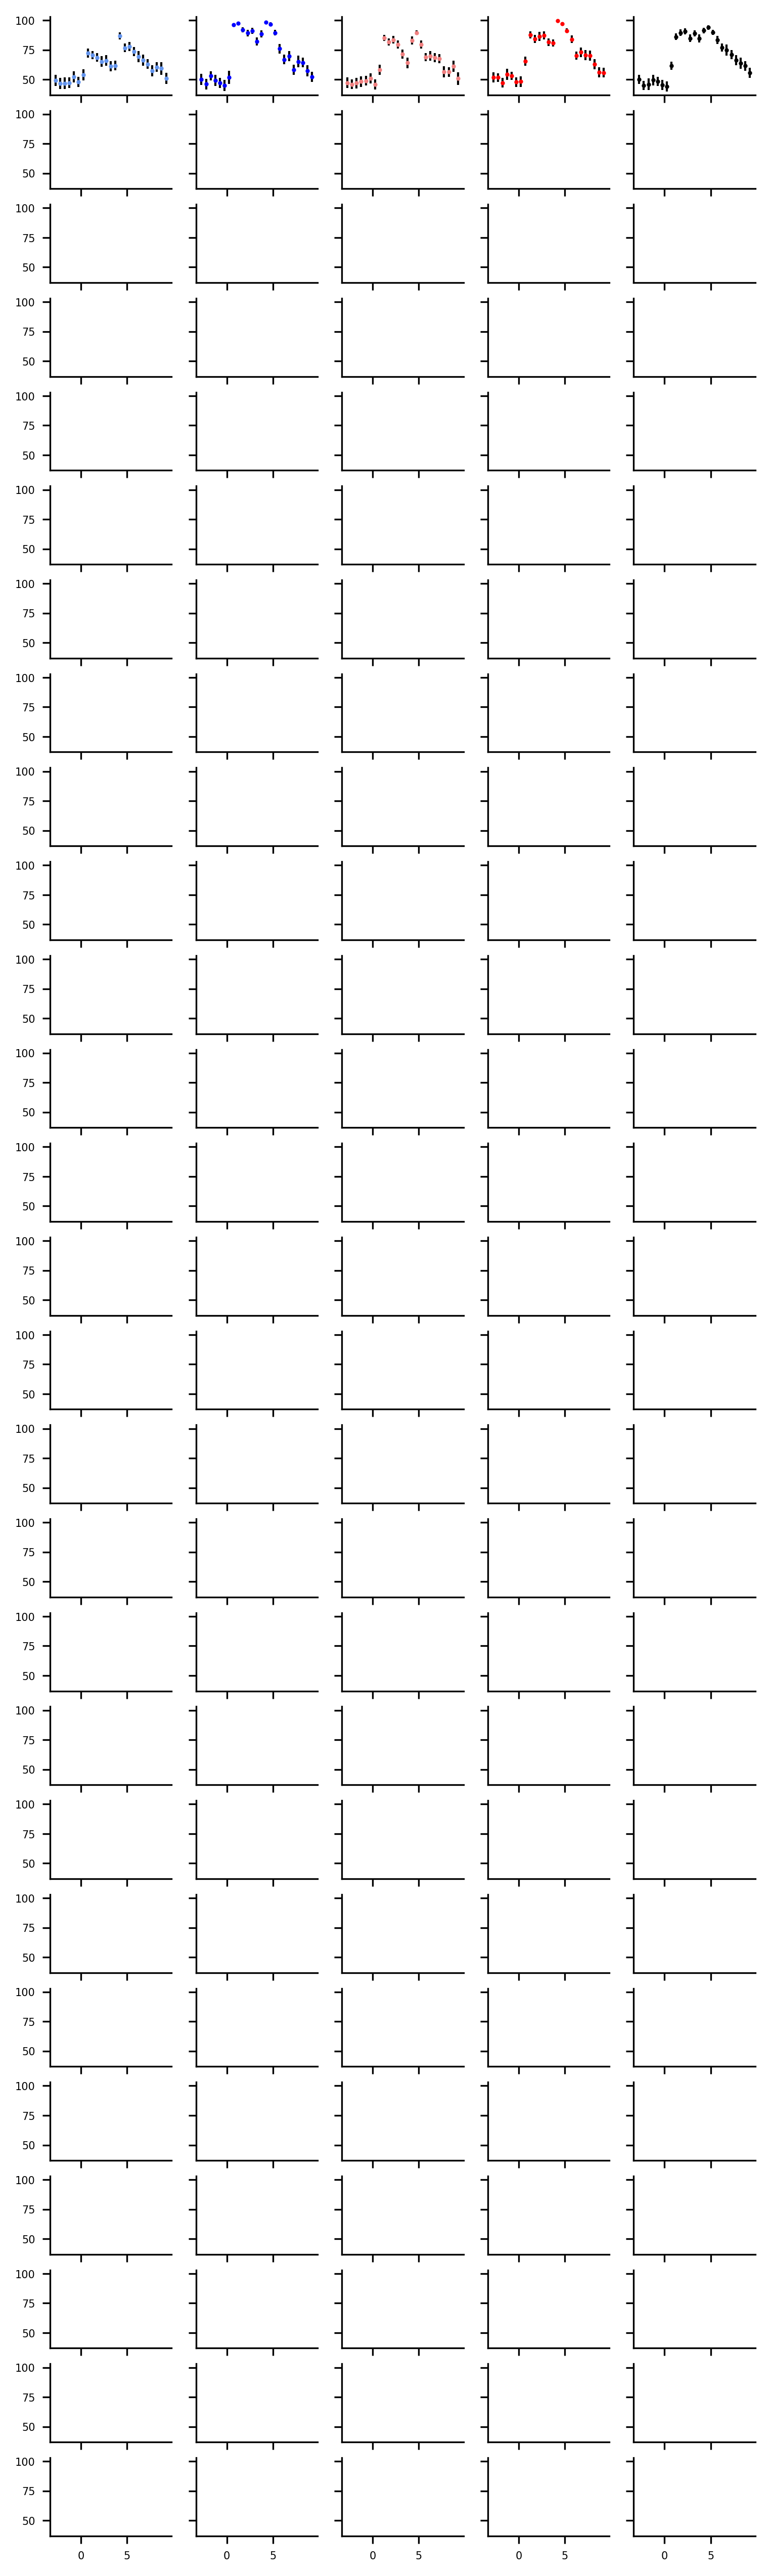

In [11]:
plot_ref_scores('rwVSsh','top_20_abs',ylabel='Perfromance\n(best 20 cells)',subset_cells_overlay=True)

In [ ]:
plot_ref_scores('rwVSsh','bottom15_abs',ylabel='Perfromance\n(abs >15th %ile)',subset_cells_overlay=True)

In [ ]:
save_workspace(db)